In [1]:
import import_ipynb                #pip install import_ipynb
from NimbRoNet2 import *
from Utils import *
from Transformation import *
from CustomDataset import *
import torch
import sys
import torch.optim as optim

if torch.cuda.is_available():
    avDev = torch.device("cuda")
else:
    avDev = torch.device("cpu")

batch_size = 5

print("Device : ",avDev)
print("Python Version : ",sys.version)
print("Pytorch Version : ",torch.__version__)

importing Jupyter notebook from NimbRoNet2.ipynb
importing Jupyter notebook from Utils.ipynb
importing Jupyter notebook from Transformation.ipynb
importing Jupyter notebook from CustomDataset.ipynb
Device :  cuda
Python Version :  3.7.5 (default, Oct 25 2019, 15:51:11) 
[GCC 7.3.0]
Pytorch Version :  1.3.1


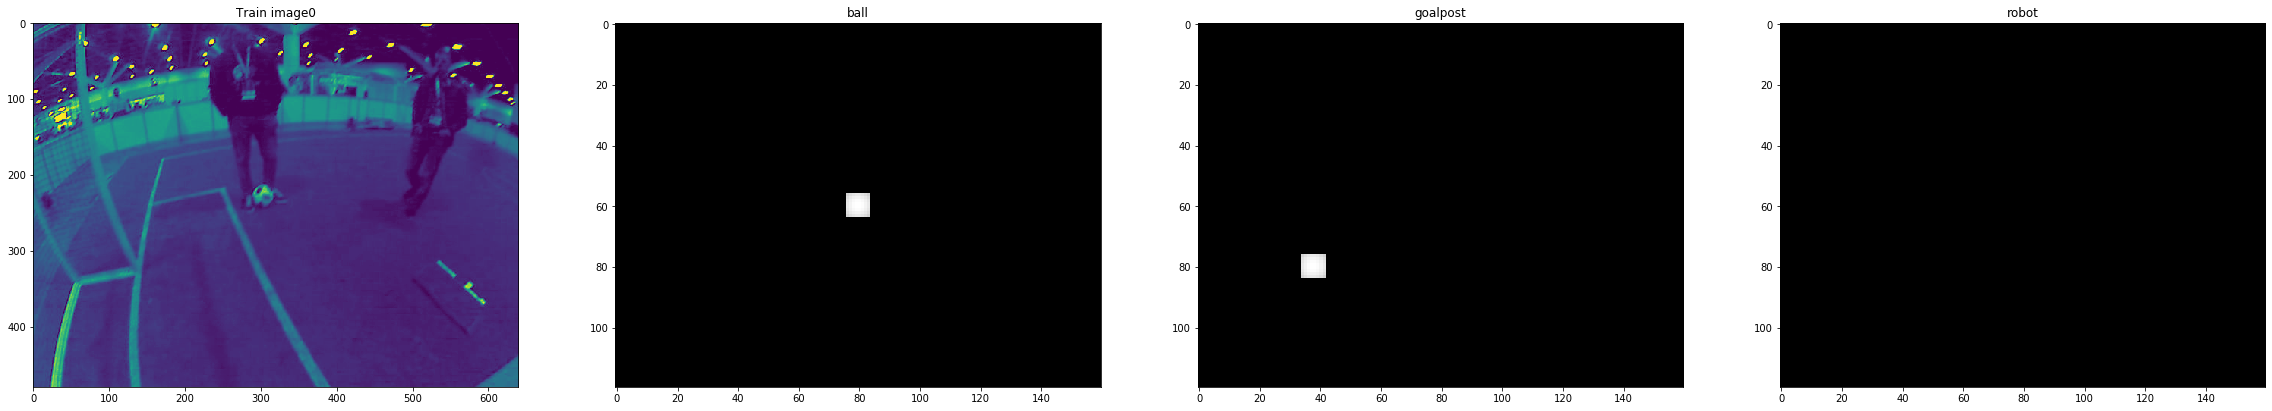

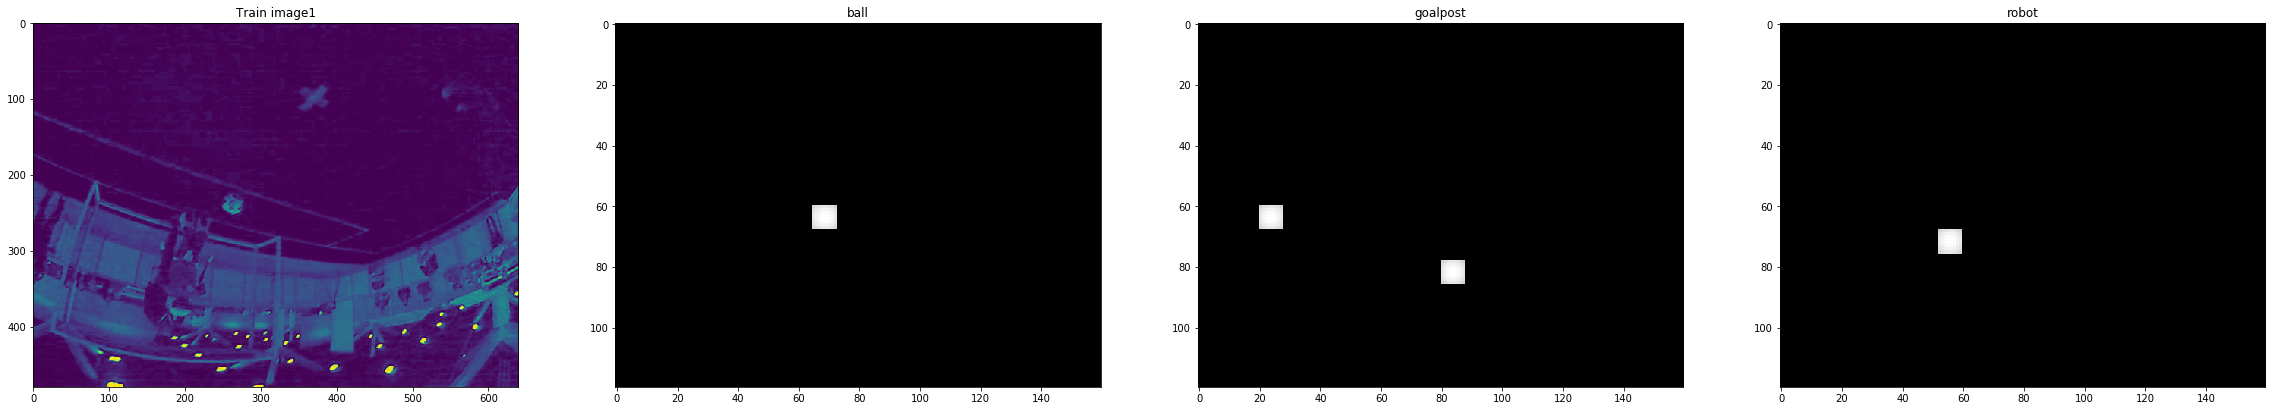

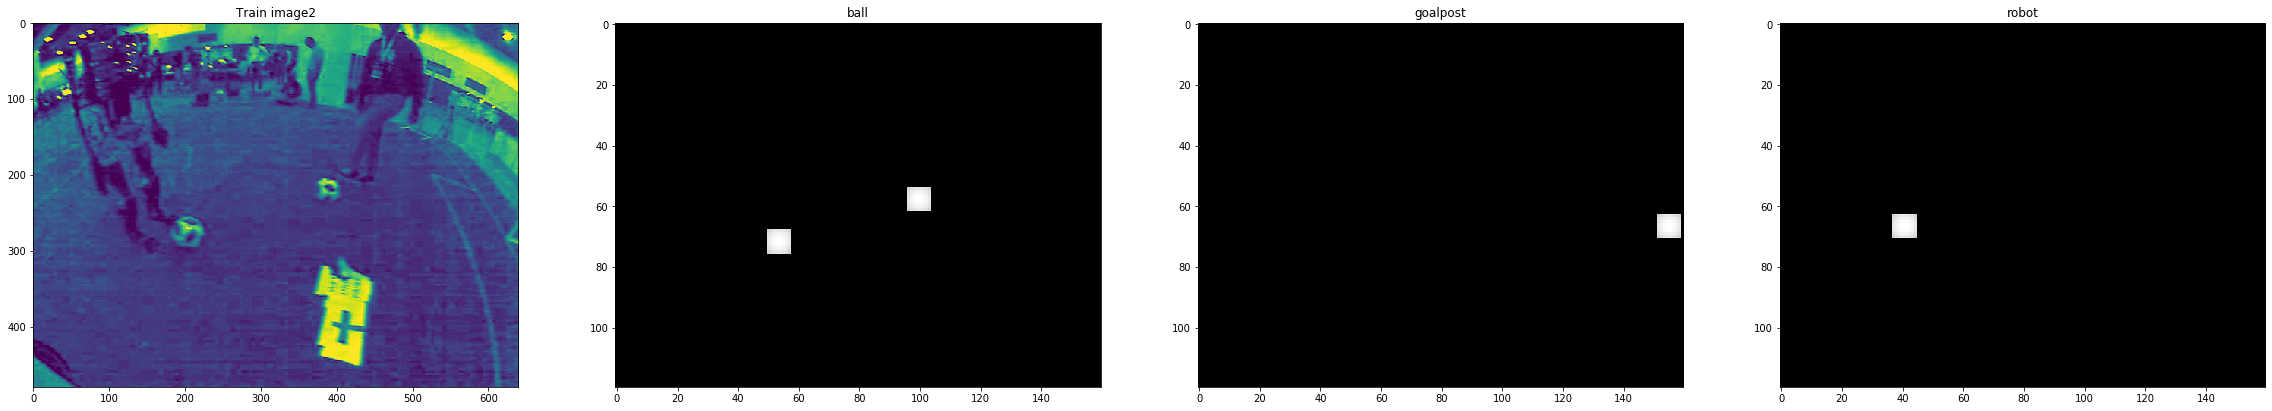

Blob Train Dataset :  3598
Segmentation Train Dataset :  1108


In [2]:
train_transforms = [Rescale((480,640)),
              RandomVerticalFlip(),
              RandomHorizontalFlip(),
              ColorJitter(brightness=0.5, 
                          contrast=0.5, 
                          saturation=0.5,
                          hue = 0.5),
              ToTensor(), 
              Normalize([0.485, 0.456, 0.406], 
                        [0.229, 0.224, 0.225])]

train_dataset = BlobTrainDataset(path = '../Project/data/blob/forceTrain',transform=train_transforms)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)



print_dataloader(train_loader, num_of_image= 3, avDev = avDev)

print("Blob Train Dataset : ",len(train_dataset))

seg_train_dataset = SegDataset(path = '../Project/data/segmentation/dataset', transform= None)
seg_train_loader = torch.utils.data.DataLoader(dataset=seg_train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

print("Segmentation Train Dataset : ",len(seg_train_dataset))

# k = 0
# for i, test_data in enumerate(seg_train_loader):
    
#     for j in range(batch_size):
#         print(test_data[0][j].size())
#         plt.figure(figsize=(10,5))
#         plt.subplot(1,2,1)
#         plt.imshow(test_data[0][j].cpu())
#         plt.subplot(1,2,2)
        
#         plt.imshow(test_data[1][j].cpu())
#         plt.show()
#     k = k + 1
#     if k == 2:
#         break

In [3]:
model = NimbRoNet2()
model.to(avDev)

criterion = nn.MSELoss()
criterion.to(avDev)

optimizer = optim.Adam([
                        {"params":model.e_block1.parameters(), "lr": 0.000001},
                        {"params":model.e_block2.parameters(), "lr": 0.000001},
                        {"params":model.e_block3.parameters(), "lr": 0.000001},
                        {"params":model.e_block4.parameters(), "lr": 0.000001},
                        {"params":model.d_block1.parameters()},
                        {"params":model.d_block2.parameters()},
                        {"params":model.d_block3.parameters()},
                        {"params":model.d_block4.parameters()},
                        {"params":model.conv_1_1.parameters()},
                        {"params":model.conv_1_2.parameters()},
                        {"params":model.conv_1_3.parameters()}], lr=0.001)

# checkpoint = torch.load("../model.pth")
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# no_epoch = checkpoint['epoch']
# print("No of epoch : ",no_epoch)
# train_loss_1 = checkpoint['train_loss1']

TypeError: __init__() missing 7 required positional arguments: 'locationAware', 'gradient', 'w', 'h', 'in_channels', 'out_channels', and 'kernel_size'

In [ ]:
total_loss = 0.0
loss_details = [None]*100
for epoch in range(5):

    print("epoch",epoch)
    train_loss_, model = train_model(model, "blob", train_loader, criterion, optimizer, avDev)
    loss_details[epoch] = train_loss_
    print("train loss",train_loss_)
    total_loss += train_loss_
    print("total loss", total_loss)

In [ ]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss1': loss_details,
            }, "../model.pth")


In [ ]:
test_transforms = [Rescale((480,640)),
              ToTensor(), 
              Normalize([0.485, 0.456, 0.406], 
                        [0.229, 0.224, 0.225])]

test_dataset = BlobTestDataset(path = '../Project/data/blob/forceTest',transform=test_transforms)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=1, 
                                           shuffle=True)


In [ ]:
model.eval()

test_loss = 0
recall = torch.zeros(3)
tp = torch.zeros(3)
fp = torch.zeros(3)
fn = torch.zeros(3)
fdr = torch.zeros(3)
acc = torch.zeros(len(test_loader))

for i, test_data in enumerate(test_loader):
    
    images = test_data["image"].to(avDev)
    ball = test_data["ball_detail"].to(avDev)
    goalpost = test_data["goalpost_detail"].to(avDev)
    robot = test_data["robot_detail"].to(avDev)
    
    images.requires_grad_(False)
    ball.requires_grad_(False)
    goalpost.requires_grad_(False)
    robot.requires_grad_(False)
    
    output = model(images)
    
    batch_len = output.shape[0]
    
    for j in range(batch_len):
        
        ball_center = center_of_shape(output[j][0].cpu().detach().numpy())
        b_tp, b_fn, b_fp = metric_calculation(ball[j], ball_center, 4)
        tp[0] += b_tp
        fp[0] += b_fp
        fn[0] += b_fn
        
        goalpost_center = center_of_shape(output[j][1].cpu().detach().numpy())
        g_tp, g_fn, g_fp = metric_calculation(goalpost[j], goalpost_center, 4)
        tp[1] += g_tp
        fp[1] += g_fp
        fn[1] += g_fn
        
        robot_center = center_of_shape(output[j][2].cpu().detach().numpy())
        r_tp, r_fn, r_fp = metric_calculation(robot[j], robot_center, 4)
        tp[2] += r_tp
        fp[2] += r_fp
        fn[2] += r_fn
        
    acc[i] = torch.mean(tp) / (torch.mean(tp) + torch.mean(fn) + torch.mean(fp))

for i in range(3):
    recall[i] = (tp[i])/(tp[i]+fn[i])
    fdr[i] = (fp[i])/(fp[i]+tp[i])

In [ ]:
print("Recall of Ball "+str(round(float(recall[0]),2)) )
print("Recall of Goalpost "+str(round(float(recall[1] ),2)))
print("Recall of Robot "+str(round(float(recall[2]),2)) )

print("FDR of Ball "+str(round(float(fdr[0] ),2)))
print("FDR of Goalpost "+str(round(float(fdr[1]),2)))
print("FDR of Robot "+str(round(float(fdr[2]),2)))

total_recall = torch.mean(recall)
total_fdr = torch.mean(fdr)

print("Total recall "  +str(round(float(total_recall),2)))
print("Total FDR "  +str(round(float(total_fdr),2)))
print("Accuracy " +str(round(float(acc.mean()),2)))

In [ ]:
k=1
for j,test_data in enumerate(test_loader):
      
    images = test_data["image"].to(avDev)
    ball = test_data["ball_detail"].to(avDev)
    goalpost = test_data["goalpost_detail"].to(avDev)
    robot = test_data["robot_detail"].to(avDev)
    
    images.requires_grad_(False)
    ball.requires_grad_(False)
    goalpost.requires_grad_(False)
    robot.requires_grad_(False)

    batch = test_data['image'].shape[0]
    
    for i in range(batch):
        k += 1
        plt.figure(figsize=(40,20))
        plt.subplot(2,3,1)
        plt.title('Test image' + str(k))
        plt.imshow(images[i][0].cpu())
        out = model(images)
        plt.subplot(2,3,2)
        plt.title('Ball')
        plt.imshow(out[i][0].cpu().detach().numpy(), cmap= 'gray')
        plt.subplot(2,3,3)
        plt.title('Goalpost')
        plt.imshow(out[i][1].cpu().detach().numpy(), cmap= 'gray')
        plt.subplot(2,3,5)
        plt.title('Robot')
        plt.imshow(out[i][2].cpu().detach().numpy(), cmap= 'gray')
        plt.show()